# 🧠 Lab 01: Previsão de Séries Temporais com LSTM

**Objetivo:**
Construir, treinar e validar uma Rede Neural Recorrente (RNN) utilizando a arquitetura **LSTM (Long Short-Term Memory)** para prever a tendência do preço de abertura das ações do Google.


**Pipeline do Projeto:**

1.  **Pré-processamento de Dados:**
    * Normalização (Feature Scaling) entre 0 e 1 para facilitar a convergência.
    * Criação de uma estrutura de dados com **Janela Deslizante (Sliding Window)**: O modelo aprenderá olhando os últimos 60 dias (Time Steps) para prever o dia seguinte.
    * Reshaping dos dados para o formato tridimensional exigido pelo Keras `[Samples, Time Steps, Features]`.
    
2.  **Construção e Treinamento da LSTM:**
    * Definição de uma arquitetura empilhada (Stacked LSTM) com camadas de **Dropout** para prevenir Overfitting.
    * Utilização do otimizador **Adam** e função de perda **Mean Squared Error (MSE)**.

3.  **Previsão e Visualização:**
    * Processamento dos dados de teste.
    * Geração das previsões e transformação inversa (Inverse Transform) para a escala original de preços ($).
    * Plotagem gráfica comparando a **Tendência Real vs. Tendência Prevista**.


In [3]:
# Importações necessárias
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import EarlyStopping  
from sklearn.preprocessing import MinMaxScaler

In [4]:
# Carregando o dataset de treino 
dataset_train = pd.read_csv("../data_sample/dados_google/Google_Stock_Price_Train.csv")
dataset_train

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"
...,...,...,...,...,...,...
1253,12/23/2016,790.90,792.74,787.28,789.91,"623,400"
1254,12/27/2016,790.68,797.86,787.66,791.55,"789,100"
1255,12/28/2016,793.70,794.23,783.20,785.05,"1,153,800"
1256,12/29/2016,783.33,785.93,778.92,782.79,"744,300"


In [5]:
training_set = dataset_train.iloc[:, 1:2].values
training_set

array([[325.25],
       [331.27],
       [329.83],
       ...,
       [793.7 ],
       [783.33],
       [782.75]])

In [6]:
# Normalização
scaler = MinMaxScaler(feature_range=(0,1))
training_set_scaled = scaler.fit_transform(training_set)
training_set_scaled

array([[0.08581368],
       [0.09701243],
       [0.09433366],
       ...,
       [0.95725128],
       [0.93796041],
       [0.93688146]])

In [7]:
# Criação de estrutura de dados
# A rede vai olhar 60 dias para trás para prever o próximo
X_train = []
y_train = []
for i in range(60, 1258):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [8]:
print(X_train)

[[0.08581368 0.09701243 0.09433366 ... 0.07846566 0.08034452 0.08497656]
 [0.09701243 0.09433366 0.09156187 ... 0.08034452 0.08497656 0.08627874]
 [0.09433366 0.09156187 0.07984225 ... 0.08497656 0.08627874 0.08471612]
 ...
 [0.92106928 0.92438053 0.93048218 ... 0.95475854 0.95204256 0.95163331]
 [0.92438053 0.93048218 0.9299055  ... 0.95204256 0.95163331 0.95725128]
 [0.93048218 0.9299055  0.93113327 ... 0.95163331 0.95725128 0.93796041]]


In [9]:
X_train.shape

(1198, 60)

In [10]:
# Transformação para 3D
# A camada LSTM espera um formato 3D.
# Assim, fazemos a transformação para atender o que ela espera
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(X_train)

[[[0.08581368]
  [0.09701243]
  [0.09433366]
  ...
  [0.07846566]
  [0.08034452]
  [0.08497656]]

 [[0.09701243]
  [0.09433366]
  [0.09156187]
  ...
  [0.08034452]
  [0.08497656]
  [0.08627874]]

 [[0.09433366]
  [0.09156187]
  [0.07984225]
  ...
  [0.08497656]
  [0.08627874]
  [0.08471612]]

 ...

 [[0.92106928]
  [0.92438053]
  [0.93048218]
  ...
  [0.95475854]
  [0.95204256]
  [0.95163331]]

 [[0.92438053]
  [0.93048218]
  [0.9299055 ]
  ...
  [0.95204256]
  [0.95163331]
  [0.95725128]]

 [[0.93048218]
  [0.9299055 ]
  [0.93113327]
  ...
  [0.95163331]
  [0.95725128]
  [0.93796041]]]


In [ ]:
# Construindo da Arquitetura (Stacked LSTM)

modelo = Sequential()
# Primeira camada
modelo.add(LSTM(units=50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
modelo.add(Dropout(0.2))
# Segunda camada
modelo.add(LSTM(units=50, return_sequences = True))
modelo.add(Dropout(0.2))
# Terceira camada
modelo.add(LSTM(units=50, return_sequences = True))
modelo.add(Dropout(0.2))
# Quarta camada
modelo.add(LSTM(units=50))
modelo.add(Dropout(0.2))
# Camada de saida
modelo.add(Dense(units=1))

In [12]:
# Compilação do modelo
modelo.compile(optimizer="adam", loss='mean_squared_error')

# Treinamento
early_stopping = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=10)

# Iniciando o treinamento
modelo.fit(X_train, y_train, epochs=1, batch_size=32, callbacks=[early_stopping])

38/38 ━━━━━━━━━━━━━━━━━━━━ 13s 117ms/step - loss: 0.0459


In [ ]:
# Carregando o dataset de teste
dataset_test = pd.read_csv("../data_sample/dados_google/Google_Stock_Price_Test.csv")
real_stock_price = dataset_test.iloc[:, 1:2].values


In [14]:
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis=0)

In [16]:
inputs = dataset_total[len(dataset_total)-len(dataset_test)-60:].values
inputs

array([779.  , 779.66, 777.71, 786.66, 783.76, 781.22, 781.65, 779.8 ,
       787.85, 798.24, 803.3 , 795.  , 804.9 , 816.68, 806.34, 801.  ,
       808.35, 795.47, 782.89, 778.2 , 767.25, 750.66, 774.5 , 783.4 ,
       779.94, 791.17, 756.54, 755.6 , 746.97, 755.2 , 766.92, 771.37,
       762.61, 772.63, 767.73, 764.26, 760.  , 771.53, 770.07, 757.44,
       744.59, 757.71, 764.73, 761.  , 772.48, 780.  , 785.04, 793.9 ,
       797.4 , 797.34, 800.4 , 790.22, 796.76, 795.84, 792.36, 790.9 ,
       790.68, 793.7 , 783.33, 782.75, 778.81, 788.36, 786.08, 795.26,
       806.4 , 807.86, 805.  , 807.14, 807.48, 807.08, 805.81, 805.12,
       806.91, 807.25, 822.3 , 829.62, 837.81, 834.71, 814.66, 796.86])

In [ ]:
# Normalização dos dados de teste
inputs = inputs.reshape(-1, 1)
inputs = scaler.transform(inputs)
X_test = []
for i in range(60, 80):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = modelo.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 768ms/step


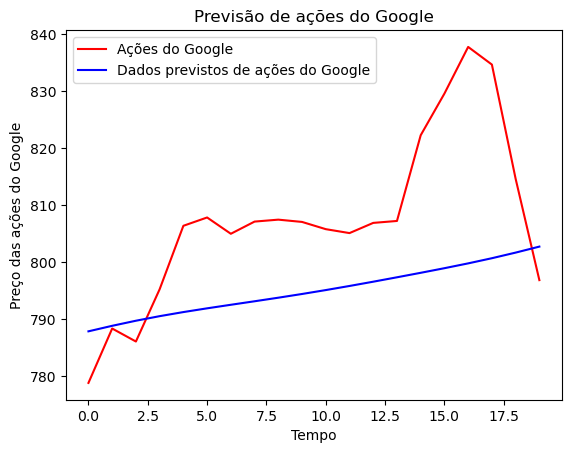

In [ ]:
# Visualização dos resultados
plt.plot(real_stock_price, color='red', label='Ações do Google')
plt.plot(predicted_stock_price, color='blue', label='Dados previstos de ações do Google')
plt.title('Previsão de ações do Google')
plt.xlabel('Tempo')
plt.ylabel('Preço das ações do Google')
plt.legend()
plt.show()